In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output

import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility

# Common modules

In [3]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)  # might have zero in the denominator
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_regression(pred_batch, truth_batch, debug=False):
        '''euclidian error when modeling the output representation is a matrix (image)\
           both pred and truth are batches, typically a batch of 32
        '''
        error = []
        for pred, truth in zip(pred_batch, truth_batch):
            pred_x, pred_y = pred[0], pred[1]
            true_x, true_y = truth[0], truth[1]
            err = Utility.distance_error((pred_x, pred_y), (true_x, true_y))
            error.append(err)
            if debug:
                print(pred, truth, err)
        return error

# 1 Regression -- output layer is a FC with two nodes

Note: don't use np.savetxt and np.loadtxt, use np.save and np.load instead. I/O in binary format is faster (almost 10x) than text format, and don't have the utf-8 encoding issue.

Assumption 1: Regression don't need that much data comparing to labeling. Because labeling needs labeled data on every cell, while regression don't. I.e. regression can lead to generalization on space. Am I talking about the labeling or segmentation here?

Assumption 2: Training sample increase linear with # TX, not exponential, with the CNN regression

In [6]:
# data
class SensorInputDatasetRegression(Dataset):
    '''Sensor reading input dataset
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, grid_len: int, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()
        self.grid_len = grid_len

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_arr = self.get_regression_target(folder, target_name)
        target_arr = self.min_max_normalize(target_arr)
        sample = {'matrix':matrix, 'label':target_arr}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_regression_target(self, folder: str, target_name: str):
        '''
        Args:
            folder: example of folder is 000001
        Return:
            a two dimension matrix
        '''
        target_file = os.path.join(self.root_dir, folder, target_name)
        target = np.load(target_file)
        return target.astype(np.float32)

    def min_max_normalize(self, target_arr: np.ndarray):
        '''scale the localization to a range of (0, 1)
        '''
        target_arr /= self.grid_len
        return target_arr

    def undo_normalize(self, arr: np.ndarray):
        arr *= self.grid_len
        return arr


tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

# training
indx = 10
root_dir = './data/matrix-train20'
sensor_input_dataset = SensorInputDatasetRegression(root_dir = root_dir, grid_len = Default.grid_length, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_dataset[indx]['matrix'].shape)
print(sensor_input_dataset[indx]['label'])
print(sensor_input_dataset.__len__())

# testing
root_dir = './data/matrix-test20'
sensor_input_test_dataset = SensorInputDatasetRegression(root_dir = root_dir, grid_len = Default.grid_length, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_test_dataset[indx]['matrix'].shape)
print(sensor_input_test_dataset[indx]['label'])
print(sensor_input_test_dataset.__len__())

torch.Size([1, 100, 100])
[0.00649767 0.01393508]
100000
torch.Size([1, 100, 100])
[0.00115267 0.05304929]
20000


In [8]:
class Net3(nn.Module):
    '''the output of the fully connected layer is 1x2 array
       assume the input matrix is 1 x 100 x 100
    '''
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.groupnorm1 = nn.GroupNorm(1, 8)
        self.groupnorm2 = nn.GroupNorm(1, 16)
        self.groupnorm3 = nn.GroupNorm(1, 32)
        self.fc1   = nn.Linear(2592, 100)
        self.fc2   = nn.Linear(100, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.groupnorm1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm3(self.conv3(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

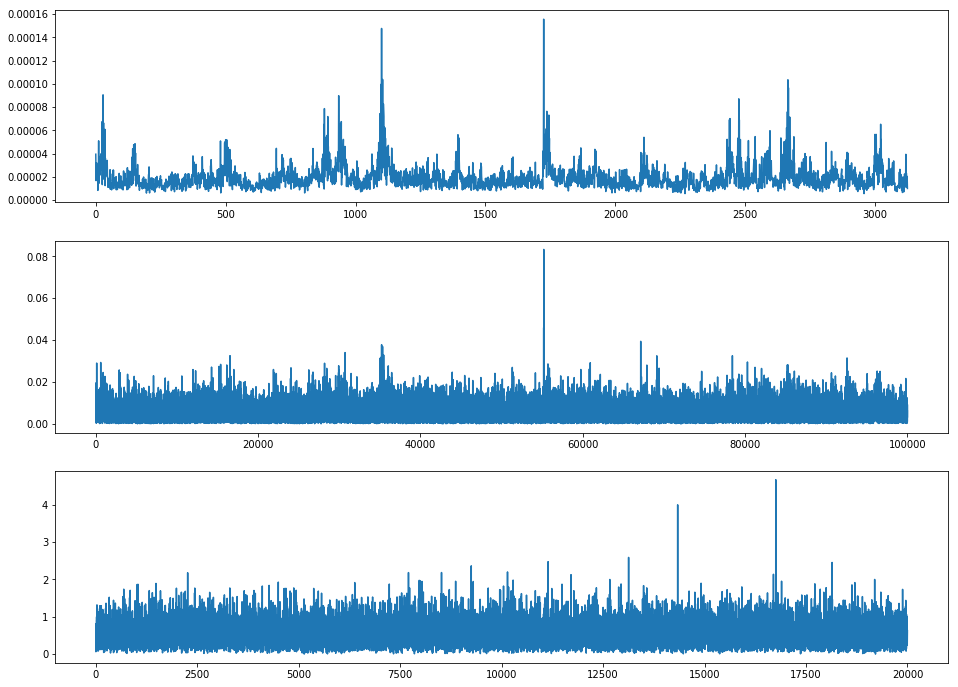

train loss mean = 1.9441607176413527e-05
train loss std  = 1.100884185082241e-05
train mean = 0.005297440887727002
train std  = 0.003289427661411997
test mean = 0.5639701860467743
test std  = 0.3076339093726988
train loss
(0.0009907200190937147, 0.02218700773714558)
(9.32204226043541e-05, 0.00010040866054695518)
(6.454806925728917e-05, 4.558665894617762e-05)
(5.0589954330644104e-05, 3.105565806306809e-05)
(3.880767836497398e-05, 2.894268025582045e-05)
(3.0275009740289532e-05, 1.8855724579381607e-05)
(2.6666560410958482e-05, 1.8321831310314873e-05)
(2.204881033132551e-05, 1.2260250751882945e-05)
(2.2017964054830374e-05, 1.3735550369026212e-05)
(1.9441607176413527e-05, 1.100884185082241e-05)
train error
(0.014246165894138314, 0.042172109045958465)
(0.011157073180468203, 0.007871503238318851)
(0.009589198721082468, 0.006094539074023851)
(0.008565006056103846, 0.005274521758944387)
(0.007429239064168077, 0.004735162458362737)
(0.006593818107430433, 0.004131777124511965)
(0.0061574378358572

In [10]:
# %%time
# training segmentation problem

net3 = Net3()
print(net3)

device    = torch.device('cuda')
model     = net3.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # criterion is the loss function

num_epochs   = 10
train_losses_epoch = []
train_errors_epoch = []
test_errors_epoch  = []
best_acc = 0
print_every = 500

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_errors  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred = pred.data.cpu()
        y = y.data.cpu()
        train_errors.extend(Metrics.localization_error_regression(pred, y))
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')

    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        pred = pred.data.cpu()
        y    = y.data.cpu()
        pred = sensor_input_dataset.undo_normalize(pred)
        y    = sensor_input_dataset.undo_normalize(y)
        test_errors.extend(Metrics.localization_error_regression(pred, y))

    clear_output(True)
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    plt.plot(train_losses)
    plt.subplot(312)
    plt.plot(train_errors)
    plt.subplot(313)
    plt.plot(test_errors)
    plt.show()

    print('train loss mean =', np.mean(train_losses))
    print('train loss std  =', np.std(train_losses))
    print('train mean =', np.mean(train_errors))
    print('train std  =', np.std(train_errors))    
    print('test mean =', np.mean(test_errors))
    print('test std  =', np.std(test_errors))
    train_losses_epoch.append((np.mean(train_losses), np.std(train_losses)))
    train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
    test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))

print('train loss')
for loss in train_losses_epoch:
    print(loss)
print('train error')
for error in train_errors_epoch:
    print(error)
print('test error')
for error in test_errors_epoch:
    print(error)

In [26]:
a = np.array(sorted(test_errors_epoch, key=lambda x:x[0])[:2])

In [35]:
print(a)

[[0.4696513  0.27151574]
 [0.5494591  0.34216362]]


In [36]:
np.save('tmp', a)

In [38]:
b = np.load('tmp.npy')

In [39]:
b

array([[0.4696513 , 0.27151574],
       [0.5494591 , 0.34216362]])

# Code about the assumption 1

## typical results without normalization
train loss
(0.002491544868775527, 0.014344682610056133)
(9.657201327965595e-05, 8.753958299285462e-05)
(0.00010165691073983907, 0.000320890286104813)
(5.2045931273023595e-05, 2.8673683110067388e-05)
(4.400959387305193e-05, 2.473582698323657e-05)
(3.6085367554333063e-05, 1.9001501424986967e-05)
train error
(0.02740393814578336, 0.06505469973471319)
(0.011612219622569954, 0.007635468683444158)
(0.010622132344197482, 0.00951231443180669)
(0.008734786136014909, 0.005272131804307188)
(0.008033107640353676, 0.004846480112375492)
(0.0072722390125086805, 0.004391500292330955)
test error
(0.9805473719326239, 0.5440884211120196)
(1.0882892673834788, 0.5753426615858586)
(0.9711083288993128, 0.497410744393391)
(1.101779616568316, 0.5489640769392788)
(0.7688395846017734, 0.41168449497125825)
(0.7029121117979286, 0.3942299395773801)

## typical results with group norm (2, x)
train loss
(0.001517590004237136, 0.034552507040551135)
(9.525805010111071e-05, 9.929480189365785e-05)
(6.940553993044887e-05, 5.2318034939872186e-05)
(5.137451244634576e-05, 4.017919251798018e-05)
(4.220958821970271e-05, 2.6746086796376148e-05)
(3.5181591841974294e-05, 2.4578940409240396e-05)
train error
(0.018349663856136275, 0.051946798241148354)
(0.011442389176750823, 0.007719315388992831)
(0.009940584062179084, 0.006324228677921738)
(0.008529858360642361, 0.005476362043039442)
(0.007787798476469229, 0.004875384229683183)
(0.007076376141209171, 0.004504229609309251)
test error
(1.2934558292399911, 0.8339005212663204)
(0.5678901878640251, 0.34372536993815106)
(1.11016089638169, 0.48358589795774404)
(0.5839268432085727, 0.333517919866665)
(0.6463828694889981, 0.34435586426650655)
(0.6986604287874104, 0.3260694951968257)
CPU times: user 1min 44s, sys: 9.9 s, total: 1min 54s
Wall time: 1min 59s

## typical results with group norm (1, x)
train loss
(0.0016219936669646996, 0.03919708517657663)
(7.50948533299379e-05, 0.00015688463221705915)
(6.82139975114842e-05, 0.00023548913384850863)
(4.709622285648948e-05, 5.1260809653704284e-05)
(3.3958442653820387e-05, 2.4809929749655018e-05)
(2.7282098822470288e-05, 1.706731261974532e-05)
train error
(0.01651740118369875, 0.05450837336766754)
(0.009910539935620789, 0.007209084911616203)
(0.00883753967716924, 0.007637138706856335)
(0.007996270396787228, 0.005500191427401991)
(0.006963482684349465, 0.004407583721370521)
(0.006270305799477473, 0.0039047999670936296)
test error
(1.3952893516564395, 0.6763274899874611)
(0.7678875913716188, 0.3611749258434536)
(0.5447681478201064, 0.34094830129654913)
(0.7686435418956585, 0.40988405976665787)
(0.9429625243745059, 0.512150043908168)
(0.6142262765393071, 0.345262403800058)

In [11]:
model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['label'].to(device)
    pred = model(X)
    pred = pred.data.cpu()
    y    = y.data.cpu()
    pred = sensor_input_dataset.undo_normalize(pred)
    y    = sensor_input_dataset.undo_normalize(y)
    errors = Metrics.localization_error_regression(pred, y, True)
    print(np.mean(errors), np.std(errors))
    break

tensor([81.8604, 70.9778]) tensor([81.2463, 70.4324]) 0.821363520563951
tensor([34.7850, 78.0341]) tensor([34.2617, 77.7381]) 0.6011951613052557
tensor([25.2517,  8.6965]) tensor([25.0208,  8.6150]) 0.24479354526258862
tensor([65.0052, 72.6798]) tensor([64.5412, 72.2562]) 0.6283308204386454
tensor([47.7142, 75.2386]) tensor([47.2225, 74.6097]) 0.7983187891432351
tensor([54.6029,  4.5446]) tensor([54.5272,  4.8098]) 0.2758239961515118
tensor([92.2542, 95.7488]) tensor([91.8010, 95.0421]) 0.839485198376089
tensor([55.5450, 88.1588]) tensor([55.0696, 87.9331]) 0.5262720591798861
tensor([37.8016, 60.6726]) tensor([37.5776, 60.4312]) 0.3292858162648682
tensor([34.6991, 61.6767]) tensor([34.2778, 61.2569]) 0.5946937138548012
tensor([33.7809, 31.3478]) tensor([33.2606, 31.4080]) 0.5237918906655047
tensor([92.5192, 73.6774]) tensor([92.3354, 72.8546]) 0.8430671754637113
tensor([60.6051, 46.9875]) tensor([60.3933, 46.6192]) 0.42486343854463643
tensor([68.3785, 66.2625]) tensor([67.9357, 65.5721

In [85]:
regression, segmentation = [], []

In [86]:
regression

[]